In [96]:
import os
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models
from torch import optim
from torchsummary import summary

import time
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve


1. 看是cuda or cpu

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [98]:
# test if GPU can use?
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


2. 超參數

In [99]:
# Hyper Parameters
LR = 0.02
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_VALID = 5
# n_iters = 10000
NUM_EPOCHS = 5

IMAGE_SIZE = 128

In [100]:
# LA train data info
train_df = pd.read_csv("train_info.csv")

3. 實作一個可以讀取 Spectrogram image 的 Pytorch dataset

In [101]:
class SpectrogramDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, labels, transform):
        self.filenames = filenames    # 資料集的所有檔名
        self.labels = labels          # 影像的標籤
        self.transform = transform    # 影像的轉換方式
 
    def __len__(self):
        return len(self.filenames)    # return DataSet 長度
 
    def __getitem__(self, idx):       # idx: Inedx of filenames
        # Transform image
        image = self.transform(Image.fromarray((self._remove_margin(self.filenames[idx]))[1].astype('uint8')).convert('RGB'))
        label = np.array(self.labels[idx])
        return image, label           # return 模型訓練所需的資訊
    
    def _remove_margin(self, image_path):
        # Load the image
        img = Image.open(image_path)
        img2 = np.array(img)

        # Find the bounding box of the non-background region
        non_bg_indices = np.argwhere(img2 != 255)  # Assuming the background is white (255)
        min_row, min_col, _ = np.min(non_bg_indices, axis=0)
        max_row, max_col, _ = np.max(non_bg_indices, axis=0)

        # Crop the image to the bounding box
        cropped_img = img2[min_row + 25:max_row-38, min_col + 61:max_col+1] # 自行調數值刪掉空白

        return img, cropped_img

4. 定義 Normalize 以及 Transform 的參數

In [95]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
train_transformer = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # normalize
])
 
valid_transformer = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    # normalize
])

5. 由folder path讀取image，並做transformer，分成70% 30% train 和 valid DATA

In [103]:
def split_Train_Val_Data(data_dir):
    image_paths = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
    # Load Labels
    # Assuming 'train_df' has columns 'filename' and 'target'
    # skip the "spec_" and ".png"
    labels = [train_df[train_df["filename"] == os.path.basename(path)[5:-4]]["target"].values[0] for path in image_paths]

    # 使用相同的隨機種子洗牌兩個列表
    np.random.seed(42)
    np.random.shuffle(image_paths)
    np.random.seed(42)
    np.random.shuffle(labels)
    
    # Define Train and Validation Sizes
    train_size = int(0.7 * len(image_paths))
    valid_size = len(image_paths) - train_size

    # Split into train and validation sets
    # save the file path
    train_image_paths = image_paths[:train_size]
    valid_image_paths = image_paths[train_size:]

    # save the label
    train_labels = labels[:train_size]
    valid_labels = labels[train_size:]

    # Dataset parameters: (self, all filenames, all labels, transform)
    train_dataloader = torch.utils.data.DataLoader(SpectrogramDataset(train_image_paths, train_labels, train_transformer),
                                  batch_size = BATCH_SIZE_TRAIN, shuffle = True)
    valid_dataloader = torch.utils.data.DataLoader(SpectrogramDataset(valid_image_paths, valid_labels, valid_transformer),
                                  batch_size = BATCH_SIZE_VALID, shuffle = False)

    return train_dataloader, valid_dataloader

6. 得到dataloader，設置模型、loss function、optimizer

In [104]:
# Load Images from a Folder
image_folder_path = "D:/graduate_project/src/spec_LATrain_audio_shuffle1_NOT_preprocessing"

train_dataloader, valid_dataloader = split_Train_Val_Data(image_folder_path) # 輸入folder path
vgg16_model = models.vgg16(pretrained=True).to(device)     # 使用內建的 model

# 調整成是兩個輸出神經元，真或假
# # Freeze all layers except the final classifier
# for param in vgg16_model.parameters():
#     param.requires_grad = False

# Freeze all layers except the final classifier
for name, param in vgg16_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# Modify the final classifier
num_features = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Linear(num_features, 2)  # Modify to have 2 output features

# Loss function
criterion = nn.CrossEntropyLoss()
 # Optimizer
optimizer = optim.SGD(vgg16_model.parameters(), lr = LR)
summary(vgg16_model, (3, IMAGE_SIZE, IMAGE_SIZE)) # 利用 torchsummary 的 summary package 印出模型資訊，input size: (3, IMAGE_SIZE, IMAGE_SIZE)


C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [92]:
# 最後幾層分類器
vgg16_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

7. 開始訓練模型

Epoch [1/5], Train Loss: 0.6425, Train Accuracy: 68.14%, Valid Loss: 0.4391, Valid Accuracy: 82.33%
Epoch [2/5], Train Loss: 0.4558, Train Accuracy: 78.00%, Valid Loss: 0.3983, Valid Accuracy: 87.33%
Epoch [3/5], Train Loss: 0.3718, Train Accuracy: 83.29%, Valid Loss: 0.3042, Valid Accuracy: 87.00%
Epoch [4/5], Train Loss: 0.3019, Train Accuracy: 87.43%, Valid Loss: 0.3592, Valid Accuracy: 84.00%
Epoch [5/5], Train Loss: 0.3357, Train Accuracy: 85.29%, Valid Loss: 0.2922, Valid Accuracy: 87.33%


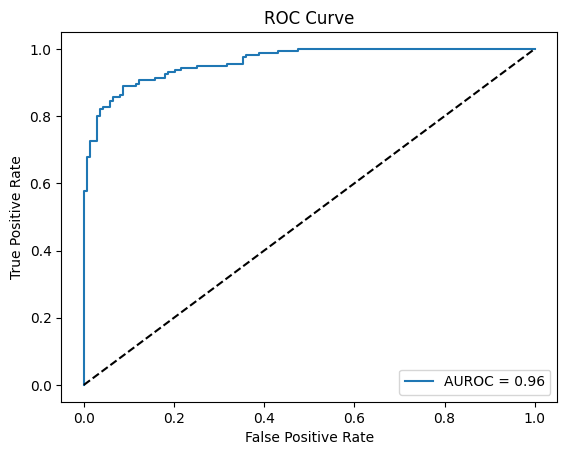

[[114  25]
 [ 13 148]]


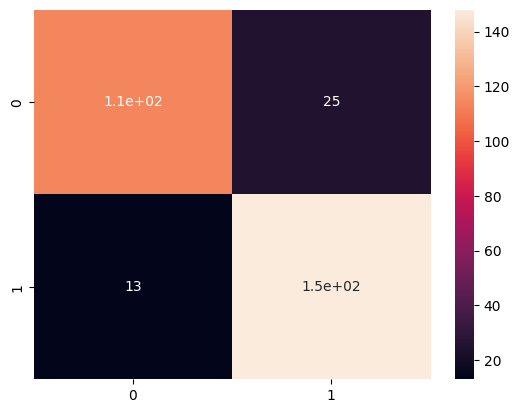

In [105]:
# store loss and acc data
Total_training_loss = []
Total_training_accuracy = []
Total_validation_loss = []
Total_validation_accuracy = []

# 訓練模型
def training(model):
    for epoch in range(NUM_EPOCHS):
        model.train() # 訓練模式
        train_loss = 0.0
        total_train = 0
        correct_train = 0
        for _, (image, label) in  enumerate(train_dataloader):
            # move tensors to GPU if CUDA is available
            image, label = image.to(device), label.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(image)
            # calculate the batch loss
            loss = criterion(outputs, label)
            
            loss.backward()
            # Update the parameters
            optimizer.step()
            
            # update training loss
            train_loss += loss.item()*image.size(0)
            
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)

            total_train += label.size(0)
            correct_train += (predicted == label).sum().item()
          
        model.eval() # 改變成測試模式
        valid_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_pred = []
        all_label = []
        with torch.no_grad():
            for _, (image, label) in enumerate(valid_dataloader):
                # move tensors to GPU if CUDA is available
                image, label = image.to(device), label.to(device)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(image)
                # calculate the batch loss
                loss =criterion(output, label)
                # update training loss
                valid_loss += loss.item()*image.size(0)

                probs = torch.nn.functional.softmax(output, dim=1)
                _, predicted = torch.max(probs, 1)

                # Extract the probabilities for class 1 (positive class)
                probs_class_1 = np.array(probs)[:, 1] # for draw the roc

                all_probs.extend(probs_class_1)
                all_pred.extend(predicted.cpu().numpy())
                all_label.extend(label.cpu().numpy())
                total += label.size(0)
                correct += (predicted == label).sum().item()

            # 計算每個樣本的平均損失
            train_loss = train_loss / len(train_dataloader.dataset)
            valid_loss = valid_loss / len(valid_dataloader.dataset)
            Total_training_loss.append(train_loss)
            Total_validation_loss.append(valid_loss)
            
        # 計算準確率
        accuracy_train = 100 * correct_train / total_train
        accuracy_valid = 100 * correct / total
        Total_training_accuracy.append(accuracy_train)
        Total_validation_accuracy.append(accuracy_valid)
        print(f'Epoch [{epoch+1}/{NUM_EPOCHS:d}], Train Loss: {train_loss:.4f}, Train Accuracy: {accuracy_train:.2f}%, Valid Loss: {valid_loss:.4f}, Valid Accuracy: {accuracy_valid:.2f}%')

    # 計算 AUROC
    roc_auc = roc_auc_score(all_label, all_probs)
        
    # 繪製 ROC 曲線
    fpr, tpr, _ = roc_curve(all_label, all_probs)
    plt.plot(fpr, tpr, label='AUROC = {:.2f}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()     
        
    # confusion_matrix
    cm = confusion_matrix(all_label, all_pred)
    print(cm)
    sn.heatmap(cm, annot=True)

# Start training
if __name__ == "__main__":
    training(vgg16_model)

8. 繪製loss、accuracy變化圖

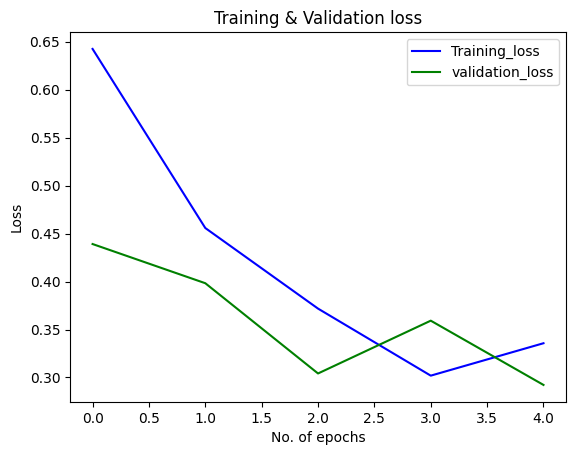

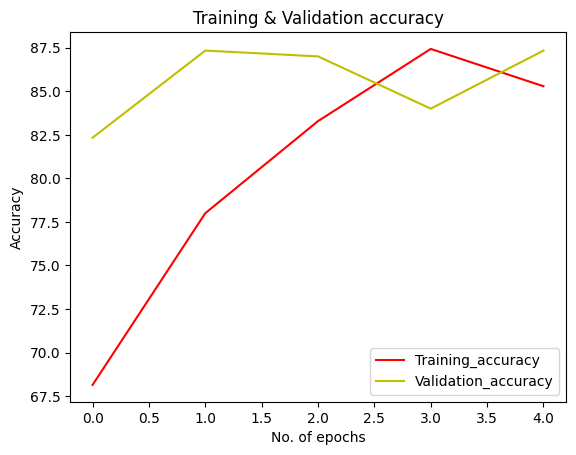

In [106]:
# visualization the loss and accuracy
plt.plot(range(NUM_EPOCHS), Total_training_loss, 'b-', label='Training_loss')
plt.plot(range(NUM_EPOCHS), Total_validation_loss, 'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('No. of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(range(NUM_EPOCHS), Total_training_accuracy, 'r-', label='Training_accuracy')
plt.plot(range(NUM_EPOCHS), Total_validation_accuracy, 'y-', label='Validation_accuracy')
plt.title('Training & Validation accuracy')
plt.xlabel('No. of epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()